# Surface Mining Screening <img align="right" src="../Supplementary_data/DE_Africa_Logo_Stacked_RGB_small.jpg">

* **Products used:** 
[ga_ls8c_wofs_2](https://explorer.digitalearth.africa/ga_ls8c_wofs_2), 
[s2_12a](https://explorer.digitalearth.africa/s2_12a)
[WOFS](https://explorer.digitalearth.africa/products/ls_usgs_wofs_scene/extents)

## Background

[Surface mining](https://americanmineservices.com/types-of-surface-mining) refers to the removal of the terrain surface to access minerals underneath. In particular, surface mining is used to retrieve sand, gravel, stones, coal, iron and other metals. Surface mining is often more cost-effective than gouging tunnels and subterranean shafts to access minerals underground.

Although surface mining contributes to the source of income for a country, these operations can result in deleterious impacts on farmlands, forests, and water bodies. Government officials are making efforts to identify areas of these mining activities. 

This notebook demonstrates a method for identifying areas where there is surface mining activities. The notebook combined with methods based on vegetation loss and water detection. Although the notebook aids in detecting these areas further verification by government agencies or institutions are required to validate the operations on the ground.

## Description

Surface mining operations often result in the clearing of vegetation and the develpoment of water from the land. Using remote sensing images Sentinel-2 and DE Africa's Water Observations from Space (WOfS) product, this notebook screen areas where there is a possibility of surface mining. 

The notebook uses Normalised Difference Vegetation Index from Rouse 1973 (NDVI) to determine vegetation loss using a threshold less than Zero. Water indices used are DE Africa's Water Observations from Space (WOfS), Normalised Difference Moisture Index from Gao 1996 (MNDWI) and Water Index from Fisher 2016 (WI) for the surface water. The three water indices compliment each other.

The final product is the combination of the Vegetation loss pixel and the pixel of water to get the mining pixel of an area.
In most cases, these algorithms can be used to identify clusters of pixels that have experienced change and allow targeted investigation of those areas by local or regional governments.

The notebook demonstrates how to:

1. Load data for a given location and time period
2. Calculate the vegetation change using NDVI
3. Compare the water extent for two time periods
4. Combine vegetation change and water extent change into one plot to show possible mining areas

***

In [1]:
%matplotlib inline

import sys
import datacube
import numpy as np
import pandas as pd
import xarray as xr
import rasterio
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.cm import RdYlGn
from datacube.utils import geometry
from matplotlib.patches import Patch
import matplotlib._color_data as mcd
from matplotlib.colors import ListedColormap
from datacube.utils.cog import write_cog



sys.path.append('../Scripts')
from odc.algo import xr_geomedian
from deafrica_bandindices import calculate_indices
from deafrica_dask import create_local_dask_cluster
from deafrica_datahandling import load_ard, wofs_fuser, mostcommon_crs
from deafrica_plotting import display_map, map_shapefile, rgb
from deafrica_spatialtools import xr_rasterize, xr_vectorize

/env/lib/python3.6/site-packages/cligj/__init__.py:17: FutureWarning: cligj 1.0.0 will require Python >= 3.7
  warn("cligj 1.0.0 will require Python >= 3.7", FutureWarning)


### Connect to the datacube
Activate the datacube database, which provides functionality for loading and displaying stored Earth observation data.

In [2]:
dc = datacube.Datacube(app='surface_mining')

### Set up a Dask cluster

Dask can be used to better manage memory use and conduct the analysis in parallel. 
For an introduction to using Dask with Digital Earth Africa, see the [Dask notebook](../Beginners_guide/08_Parallel_processing_with_dask.ipynb).

>**Note**: We recommend opening the Dask processing window to view the different computations that are being executed; to do this, see the *Dask dashboard in DE Africa* section of the [Dask notebook](../Beginners_guide/08_Parallel_processing_with_dask.ipynb).

To activate Dask, set up the local computing cluster using the cell below.

In [3]:
create_local_dask_cluster()

/env/lib/python3.6/site-packages/distributed/node.py:155: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 33233 instead
  http_address["port"], self.http_server.port


Client Scheduler: tcp://127.0.0.1:39821 Dashboard: /user/nanaboamah/proxy/33233/status,Cluster Workers: 1 Cores: 2 Memory: 13.11 GB


### Analysis parameters

The following cell sets the parameters, which define the area of interest and the length of time to conduct the analysis over.
There is also a parameter to define how the data is split in time. Note you must specify either the path of the shapefile or use the latitude, longitude and buffer.

The parameters are:

* `vector_file`: The file path and name of a shapefile containing the extent. 
* `latitude`: The latitude at the centre of your Area of Interest (AOI) (e.g. `0.02`).
* `longitude`: The longitude at the centre of your AOI (e.g. `35.425`).
* `buffer`: The number of degrees to load around the central latitude and longitude.
For reasonable loading times, set this as `0.1` or lower.
* `time`: The date range to analyse (e.g. `('2015-01-01', '2019-09-01')`).
For reasonable results, the range should span at least two years to minimise the impact of seasonal changes.

**If running the notebook for the first time**, keep the default settings below.
This will demonstrate how the analysis works and provide meaningful results.
The example covers part of the Northern Tindiret Forest Reserve, Kenya, and uses the shapefile provided in **Supplementary Data**.

In [4]:
baseline_year = 2013
analysis_year = 2019

# vector_file = None
vector_file = "data/Apam_forest.shp"

if vector_file:
    # Read shapefile into a GeoDataFrame
    gdf = gpd.read_file(vector_file)

    # Convert all of the shapes into a datacube geometry
    geom = geometry.Geometry(gdf.unary_union, gdf.crs)
    
else:
    longitude = -1.892
    latitude = 6.31744
    buffer = 0.05
    
    lat_range = (latitude-buffer, latitude+buffer)
    lon_range = (longitude-buffer, longitude+buffer)

The code below renders a map that can be used to orient yourself with the region.

In [5]:
if not vector_file:
    display_map(lon_range, lat_range)
else:
    map_shapefile(gdf, attribute=gdf.columns[0], fillOpacity=0, weight=3)

Label(value='')

Map(center=[6.328635468846285, -1.8708615021743045], controls=(ZoomControl(options=['position', 'zoom_in_text'…

## Load and clean data from the Data Cube 
    
The first step in the analysis is to load Landsat data for the specified area of interest and time range. 

The code below will create a query dictionary for our region of interest, find the correct `crs` object for the area of interest, and then load the Landsat data using the `load_ard` function.
For more information, see the [Using load_ard notebook](../Frequently_used_code/Using_load_ard.ipynb).

In [6]:
#Create a query object
query = {
    'group_by': 'solar_day',
}

if vector_file:
    query["geopolygon"] = geom
else:
    query["x"] = lon_range
    query["y"] = lat_range

query['resolution'] = (-30, 30)

product = ['ls8_usgs_sr_scene'] #'s2_l2a'
# Identify the most common projection system in the input query
output_crs = mostcommon_crs(dc=dc, product=product, query=query)

ds = load_ard(dc=dc,
              products=product, output_crs=output_crs,
              dask_chunks={'time':1,'x':2000,'y':2000},
              measurements=["red","green","blue","nir",],
              time=(f'{baseline_year}', f'{analysis_year}'),
              scaling='normalised',
              **query)

Using pixel quality parameters for USGS Collection 1
Finding datasets
    ls8_usgs_sr_scene
Applying pixel quality/cloud mask
Re-scaling Landsat C1 data
Returning 136 time steps as a dask array


### Compute geomedian for each year
We use the geomedian to create a scientifically rigorous composite of the data. In this case, the composite is over one year. One geomedian composite is calculated for the baseline year, and one for the analysis year. For more information about computing geomedians, see the [Generating geomedian composites](../Frequently_used_code/Generating_geomedian_composites.ipynb) notebook.

In [7]:
ds_geomedian = ds.groupby('time.year').map(xr_geomedian)

In [8]:
#ds_geomedian = ds_geomedian.sel(year=[baseline_year, analysis_year])

### Calculate indices for each year

Using the `calculate_indices` functions, NDVI, MNDWI and WI are computed on the geomedian dataset.

In [9]:
ds_geomedian = calculate_indices(ds_geomedian, ['NDVI'], collection='c1')

The next line of code will trigger the delayed computations up to the point using Dask's `.compute()` method. To check the progress of the calculations use the hyperlink printed below the `create_local_dask_cluster()` cell at the top of this notebook.

In [10]:
ds_geomedian = ds_geomedian.compute()

## Apply a mask to each year
We will use the polygon from the shapefile to create a mask, so we can work with only the pixels in the area. To convert the vector polygon to a raster mask, we use `xr_rasterize`. For more information on indices, see the [Rasterising vectors & vectorising rasters](/Frequently_used_code/Rasterise_vectorise.ipynb) notebook.

In [11]:
# Convert the polygon to a raster that matches our imagery data
if vector_file:
    mask = xr_rasterize(gdf, ds_geomedian)

    # Mask dataset to set pixels outside the polygon to `NaN`
    ds_geomedian = ds_geomedian.where(mask)

Rasterizing to match xarray.DataArray dimensions (283, 279)


In [12]:
ds_shift = ds_geomedian.NDVI.shift(year=1)

In [13]:
ds_change_ndvi = ds_geomedian.NDVI - ds_shift

In [14]:
vegetation_loss_threshold = -0.2
vegetation_loss = ds_change_ndvi < vegetation_loss_threshold
vegetation_loss = vegetation_loss.where(vegetation_loss == True)

In [15]:
backgroung_image = ds_geomedian.isel(year =0).NDVI

In [16]:
size_n = vegetation_loss.year.size
color_scheme = [name for name in mcd.TABLEAU_COLORS][:size_n]

### Calculate the anomaly in vegatation for the selected years

The anomaly is calculated by subtracting the analysis year data from the baseline data to identifying the change over the two periods.
A `vegetation_loss_threshold` is set to pick out areas that vegetation was loss. The threshold can be varied depending on the area of interest.

### Calculate the area per pixel

In [17]:
pixel_length = query["resolution"][1]  # in metres
m_per_km = 1000  # conversion from metres to kilometres
area_per_pixel = pixel_length**2 / m_per_km**2

### Calculate total area of pixel, area and percentage of vegetation loss pixels

A decrease in water is also one of the indicators of potential mining sites. To identify places where water has decreased between the baseline year and the analysis year, we will be using three different measurements of water &mdash; WOfS. 

WOfS is a product that can be loaded directly from the Open Data Cube.

### Load WOfS data

As we want the time and spatial extents to match the vegetation change data, we can use the same query defined above.

In [18]:
query['resolution'] =  (-30, 30)

query['time'] = (f'{baseline_year}', f'{analysis_year}')
ds_wofs_baseline = dc.load(product=["ga_ls8c_wofs_2_annual_summary"],
             output_crs=output_crs,
             **query
            )

In [19]:
n_wet=ds_wofs_baseline.count_wet.where(ds_wofs_baseline.count_wet>=0)
n_clear=ds_wofs_baseline.count_clear.where(ds_wofs_baseline.count_clear>=0)
freq=n_wet/n_clear
freq = freq.compute()
freq_boolean = xr.where(freq > 0.1, True, False)

In [20]:
freq_sum = freq_boolean.sum('time')
freq_sum = freq_sum.where(mask)

### Plotting of Results
When water(WOFS) and vegetation loss superimposed, the area is classified as Highly potential mining site.
For areas where there was only vegetation loss there is a meduim potential of identifying mining sites at that area.

In [21]:
vegetation_loss_sum = vegetation_loss.sum('year')

Text(0.5, 1.0, 'Possible Mining Areas')

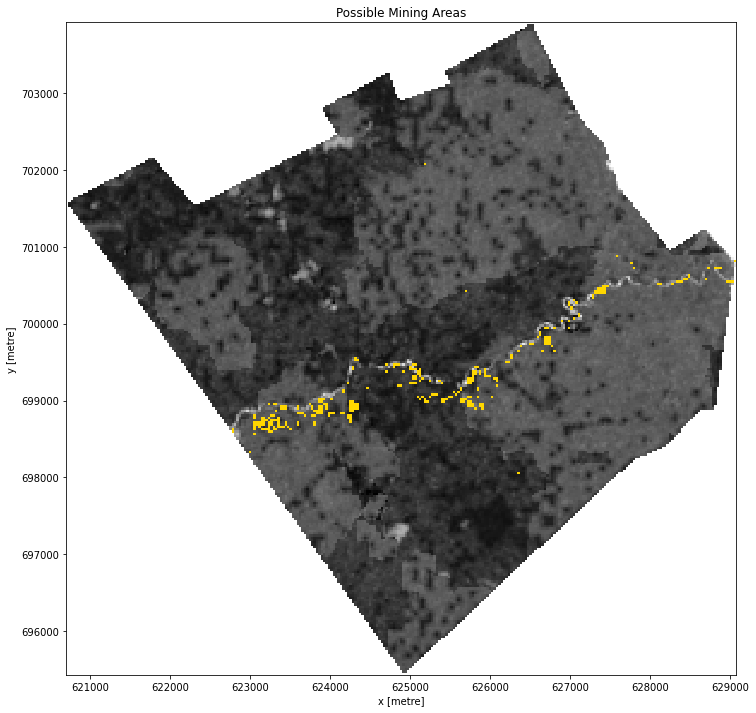

In [22]:
plt.figure(figsize=(12, 12))

#vegetation_loss = vegetation_loss.where(vegetation_loss==True)
mining_area = vegetation_loss_sum.where(freq_sum == True)

backgroung_image.plot.imshow(cmap='Greys', add_colorbar=False)

mining_area.plot.imshow(cmap=ListedColormap(['Gold']), add_colorbar=False)


# plt.legend(
#         [Patch(facecolor='Gold'), Patch(facecolor='Brown')], 
#         ['Highly Potential Mining Site', 'Medium Potential Mining Site'],
#         loc = 'upper left'
#     )

plt.title('Possible Mining Areas')

### Download the end product

In [23]:
mining_area_vector = xr_vectorize(mining_area,
                                  mask=mining_area.values==1
                                 )

In [24]:
mining_area_vector_buffer = mining_area_vector.buffer(250)

In [25]:
mining_area_buffer = xr_rasterize(gdf=mining_area_vector_buffer,
                                  da=mining_area,
                                  transform=ds.geobox.transform,
                                  crs=ds.crs)

Rasterizing to match xarray.DataArray dimensions (283, 279)


In [26]:
vegetation_loss_new = vegetation_loss_sum.where(mining_area_buffer == True)

In [27]:
vegetation_loss_new = xr.where(vegetation_loss_new > 0, True, False)
vegetation_loss_new = vegetation_loss_new.where(vegetation_loss_new == True)


In [28]:
water_new = freq_sum.where(mining_area_buffer == True)

In [29]:
water_new = xr.where(water_new > 0, True, False)
water_new =water_new.where(water_new == True)

In [30]:
vegetation_loss_new_count = vegetation_loss_new.count(dim=['x', 'y']) * area_per_pixel
water_new_count = water_new.count(dim=['x', 'y']) * area_per_pixel

total_area = water_new_count + vegetation_loss_new_count
print(total_area)

<xarray.DataArray ()>
array(1.3995)
Coordinates:
    spatial_ref  int32 32630


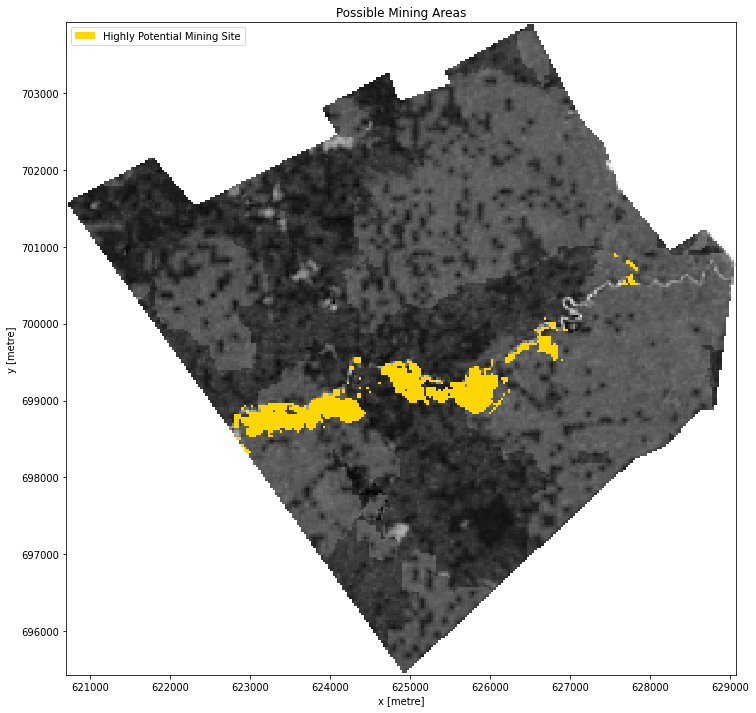

In [31]:
plt.figure(figsize=(12, 12))


backgroung_image.plot.imshow(cmap='Greys', add_colorbar=False)


vegetation_loss_new.plot.imshow(cmap=ListedColormap(['Gold']), add_colorbar=False)
water_new.plot.imshow(cmap=ListedColormap(['Gold']), add_colorbar=False)

plt.legend(
        [Patch(facecolor='Gold')], 
        ['Highly Potential Mining Site'],
        loc = 'upper left'
    )

plt.title('Possible Mining Areas')

plt.savefig('Mining_Chart')

In [32]:
vegetation_loss_mininig = vegetation_loss.where((vegetation_loss == True) & (vegetation_loss_new == True))

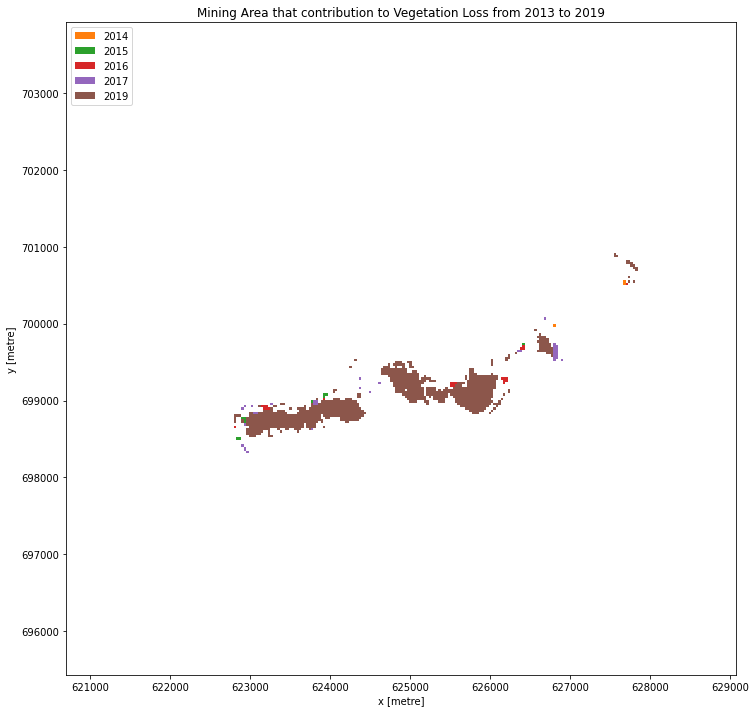

In [33]:
plt.figure(figsize=(12, 12))
color_array = []
year_array = []
for i in range(1, size_n):
    vegetation_loss_mininig.isel(year=i).plot.imshow(add_colorbar=False, cmap=ListedColormap([color_scheme[i]]))
    color_array.append(Patch(facecolor=f'{color_scheme[i]}'))
    year_array.append(f'{vegetation_loss.year.values[i]}')
    
    
plt.legend(color_array, year_array, loc = 'upper left')

plt.title(f'Mining Area that contribution to Vegetation Loss from {vegetation_loss.year.values[0]} to {vegetation_loss.year.values[-1]}')
plt.show()

Text(0, 0.5, 'Area : km sq')

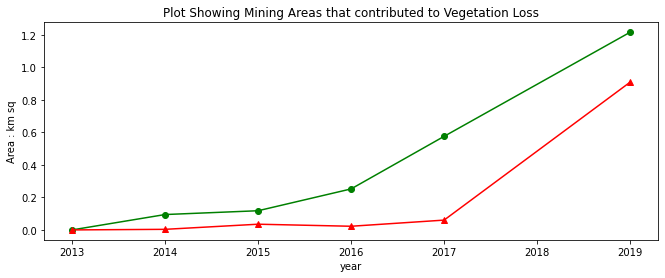

In [34]:
total_vegetation_loss_mininig = vegetation_loss_mininig.count(dim=['x', 'y'])
total_vegetation_loss = vegetation_loss.where(vegetation_loss==True).count(dim=['x', 'y'])

vegetation_loss_mininig_area = total_vegetation_loss_mininig * area_per_pixel
vegetation_loss_area = total_vegetation_loss * area_per_pixel

vegetation_loss_area.plot.line('g-o', figsize=(11, 4))
vegetation_loss_mininig_area.plot.line('r-^')

plt.title('Plot Showing Mining Areas that contributed to Vegetation Loss')
plt.ylabel('Area : km sq')

***

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Africa data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/digitalearthafrica/deafrica-sandbox-notebooks).

**Last modified:** November 2020

**Compatible datacube version:** 

In [35]:
print(datacube.__version__)

1.8.3


## Tags
Browse all available tags on the DE Africa User Guide's [Tags Index](https://) (placeholder as this does not exist yet)